In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms

### Collect data

In [4]:
DATASET_ID = 'BIRD_DB_Toxostoma_redivivum'

In [5]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [6]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'thrasher.pickle'

In [7]:
syllable_df = pd.read_pickle(df_loc)

In [8]:
syllable_df[:3]

,start_time,end_time,labels,indv,indvi,subject_importance,key,audio,rate,spectrogram
0,10.219057,10.650069,apa,CATH-TLR3,0,Primary subject,2012-02-10_10-10-00-000000,"[-0.029489595094457068, -0.0250073955299598, -...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,10.927989,11.403752,apa,CATH-TLR3,0,Primary subject,2012-02-10_10-10-00-000000,"[-0.024406587501860595, -0.017177965709986937,...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,11.864023,11.901707,axk,CATH-TLR3,0,Primary subject,2012-02-10_10-10-00-000000,"[0.07585475000128172, 0.10779280771544165, 0.1...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [19]:
syllable_df.subject_importance.unique()

array(['Primary subject', 'Background species'], dtype=object)

In [22]:
len(syllable_df)

15020

In [20]:
syllable_df = syllable_df[syllable_df.subject_importance == 'Primary subject']

In [21]:
len(syllable_df)

15020

Text(0.5, 1.0, 'min')

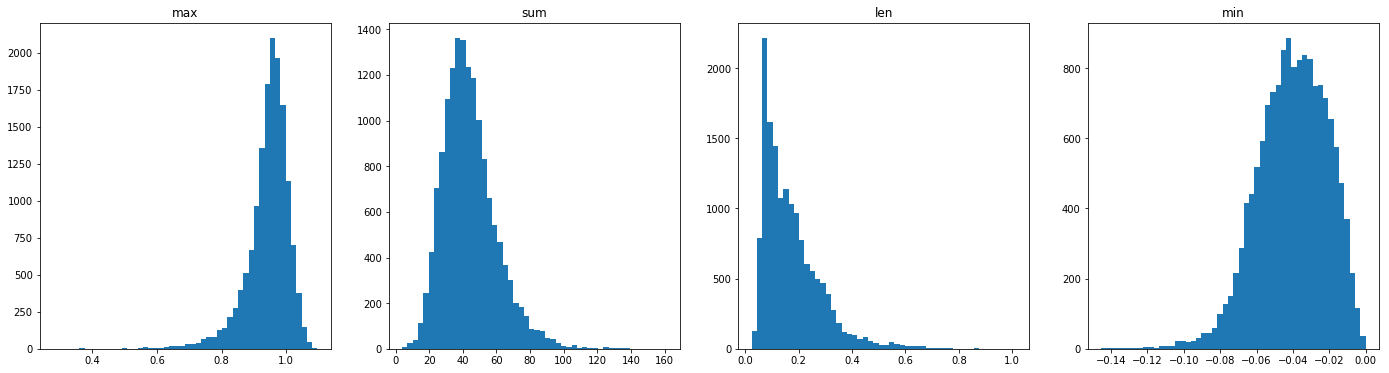

In [23]:
fig, axs = plt.subplots(ncols=4, figsize=(24,6))
axs[0].hist([np.max(i) for i in syllable_df.spectrogram.values], bins=50);axs[0].set_title('max')
axs[1].hist([np.sum(i) for i in syllable_df.spectrogram.values], bins=50);axs[1].set_title('sum')
axs[2].hist((syllable_df.end_time - syllable_df.start_time).values, bins = 50); axs[2].set_title('len')
axs[3].hist([np.min(i) for i in syllable_df.spectrogram.values], bins=50);axs[3].set_title('min')

### cluster

In [24]:
len(syllable_df)

15020

In [25]:
specs = list(syllable_df.spectrogram.values)
specs = [i / np.max(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(15020, 768)

In [26]:
fit = umap.UMAP(min_dist=0.25)

In [27]:
np.shape(specs_flattened)

(15020, 768)

In [28]:
z  = list(fit.fit_transform(specs_flattened))

In [29]:
z = np.vstack(z)

### variation across populations

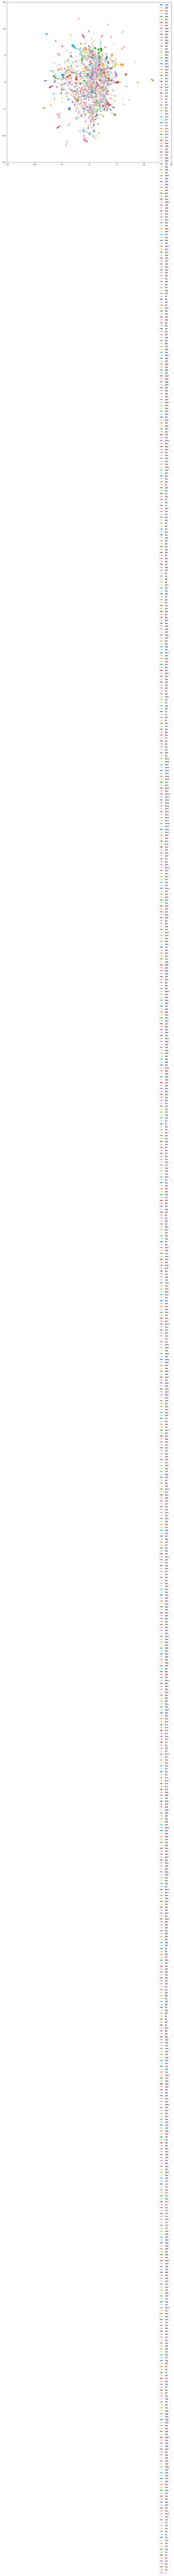

In [30]:
fig, ax = plt.subplots(figsize=(15,15))
scatter_projections(projection=z, alpha=0.25, labels = syllable_df.labels.values, s=15, ax = ax)
ax.set_xlim([-15,15])
ax.set_ylim([-15,15])
plt.show()

In [31]:
syllable_df[:3]

,start_time,end_time,labels,indv,indvi,subject_importance,key,audio,rate,spectrogram
0,10.219057,10.650069,apa,CATH-TLR3,0,Primary subject,2012-02-10_10-10-00-000000,"[-0.029489595094457068, -0.0250073955299598, -...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,10.927989,11.403752,apa,CATH-TLR3,0,Primary subject,2012-02-10_10-10-00-000000,"[-0.024406587501860595, -0.017177965709986937,...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,11.864023,11.901707,axk,CATH-TLR3,0,Primary subject,2012-02-10_10-10-00-000000,"[0.07585475000128172, 0.10779280771544165, 0.1...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


### just look at a subset

In [78]:
n_top = 10

In [79]:
top_phrases = pd.DataFrame(
    {i: [sum(syllable_df.labels == i)] for i in syllable_df.labels.unique()}
).T.sort_values(by=0, ascending=False)[:n_top]
top_phrases.T

,alc,aob,ngs,baw,bba,nfo,bbb,aut,ngn,ala
0,163,162,159,143,137,132,130,123,120,119


In [80]:
top_phrases_list = list(top_phrases.index)

In [81]:
subset_sylls = syllable_df[syllable_df.labels.isin(top_phrases_list)]

In [82]:
len(subset_sylls)

1388

In [83]:
specs = list(subset_sylls.spectrogram.values)
specs = [i / np.max(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(1388, 768)

In [84]:
fit = umap.UMAP(min_dist=0.25)

In [85]:
np.shape(specs_flattened)

(1388, 768)

In [86]:
z  = list(fit.fit_transform(specs_flattened))

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [87]:
z = np.vstack(z)

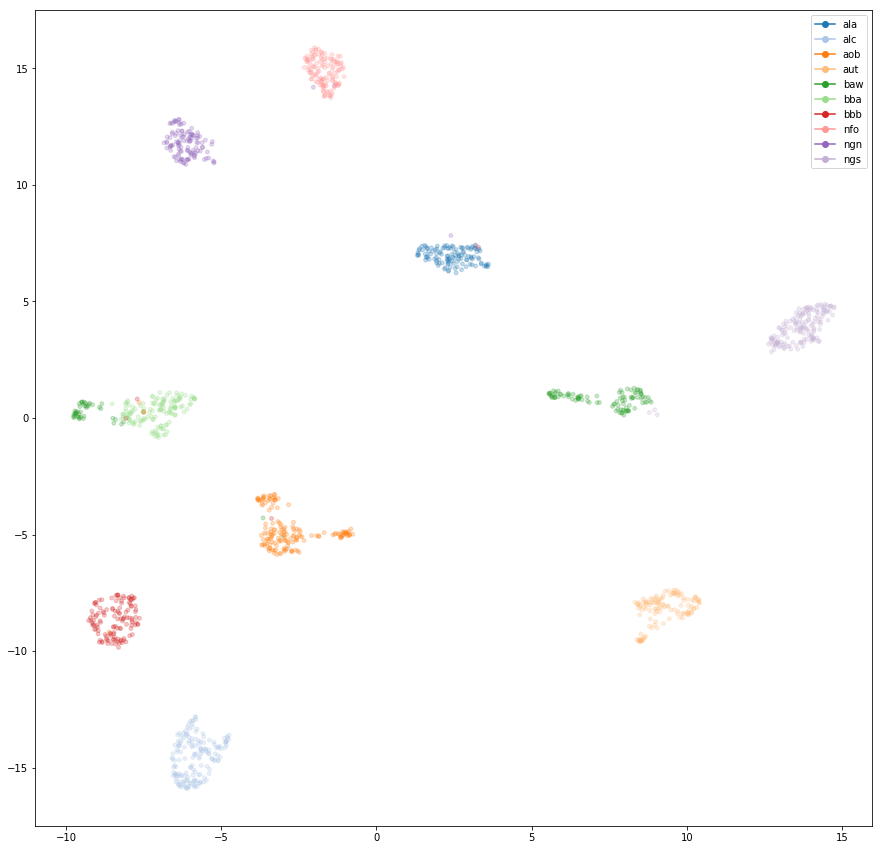

In [90]:
fig, ax = plt.subplots(figsize=(15,15))
scatter_projections(projection=z, alpha=0.25, labels = subset_sylls.labels.values, s=15, ax = ax)
#ax.set_xlim([-15,15])
#ax.set_ylim([-15,15])
plt.show()

### largest indvs

In [89]:
n_top=5
top_indv = pd.DataFrame(
    {i: [sum(syllable_df.indv == i)] for i in syllable_df.indv.unique()}
).T.sort_values(by=0, ascending=False)[:n_top]
top_indv.T

,CATH-CP1,CATH-TLR8,CATH-TLR9,CATH-TLR1,CATH-TLR2
0,2881,2618,1422,1404,1340


In [99]:
subset_sylls = syllable_df[syllable_df.indv == 'CATH-TLR8']

In [100]:
len(subset_sylls)

2618

In [101]:
specs = list(subset_sylls.spectrogram.values)
specs = [i / np.max(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(2618, 768)

In [102]:
fit = umap.UMAP(min_dist=0.25)

In [103]:
np.shape(specs_flattened)

(2618, 768)

In [104]:
z  = list(fit.fit_transform(specs_flattened))

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [105]:
z = np.vstack(z)

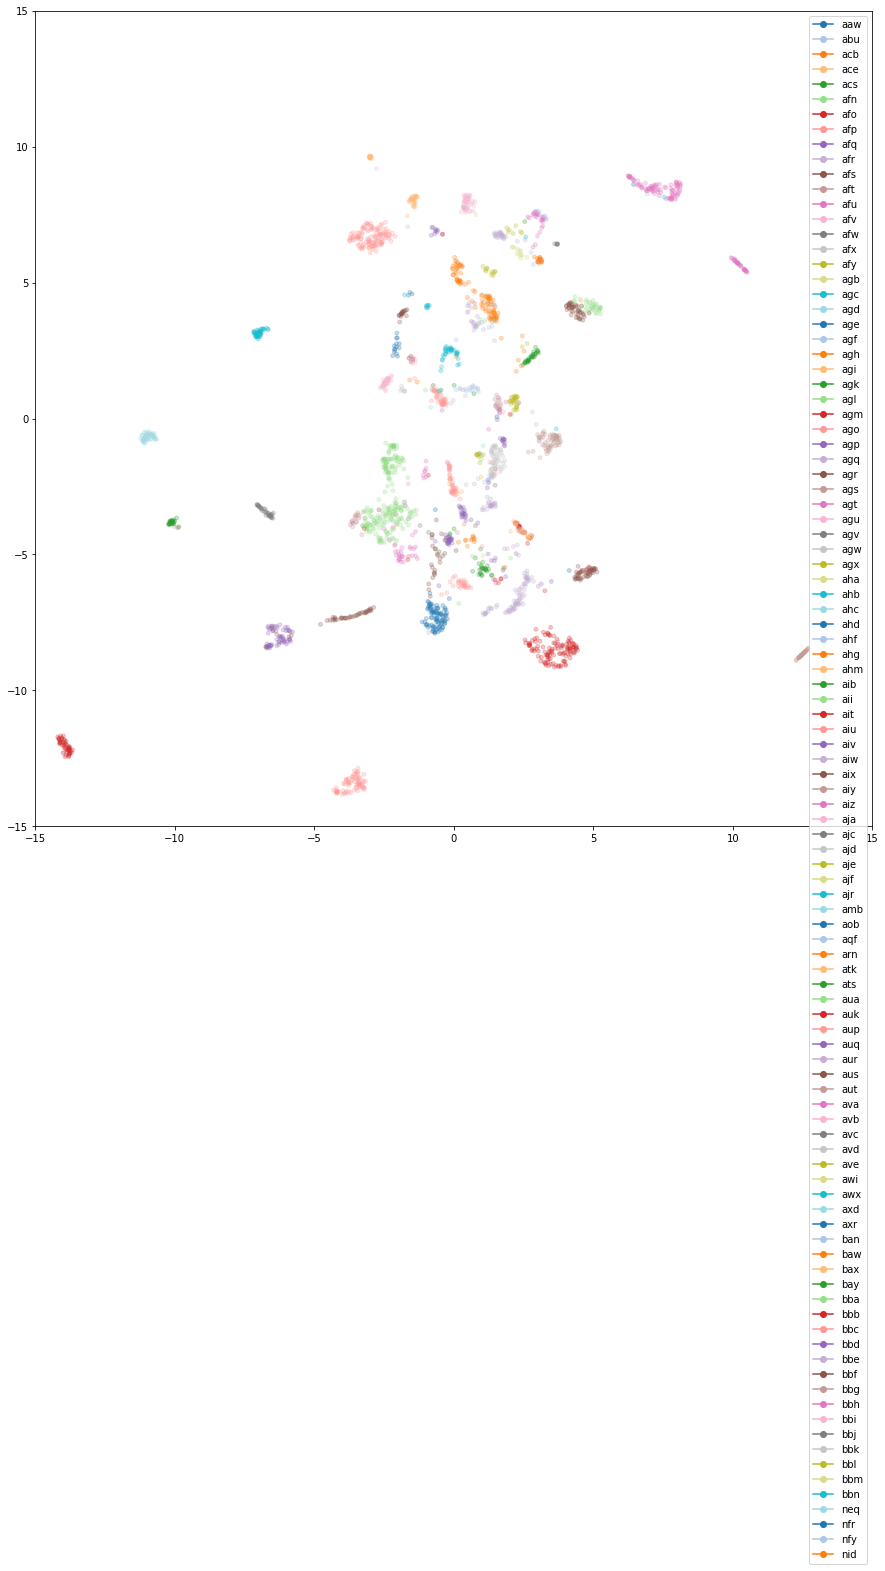

In [106]:
fig, ax = plt.subplots(figsize=(15,15))
scatter_projections(projection=z, alpha=0.25, labels = subset_sylls.labels.values, s=15, ax = ax)
ax.set_xlim([-15,15])
ax.set_ylim([-15,15])
plt.show()